In [2]:
import ast
import colorsys
import json
import cv2
import os
import multiprocessing as mp
import open3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dl.utils.io_utils import normalize_image
from dl.utils.image_transforms import depth_from_point_cloud
from dl.utils.config import DEFAULT_TONEMAP_PARAMS


In [3]:
directory_list = [f"{os.environ['DATASET_PATH']}/halo_all_cam_images_3_seconds_2_sequences"]
csv_list = ['annotations.csv']
dataset_idx = 0
directory = directory_list[dataset_idx]
csv_name = csv_list[dataset_idx]
dset_name = directory.split('/')[-1]
stereo_df_full = pd.read_csv(os.path.join(directory, csv_name), low_memory=False)
stereo_df_uniq = stereo_df_full.drop_duplicates('id')
# example_ids = ['64e6934deef031aa465115f3']
stereo_df = stereo_df_uniq[stereo_df_uniq['group_id'].isin(['1c4d5084583b42dabebf00a89e0ff270'])]
print(len(stereo_df))
# stereo_df_uniq.groupby('group_id').count()

8


In [7]:
stereo_df

,artifact_debayeredrgb_0__id,artifact_debayeredrgb_0_content_hash,artifact_debayeredrgb_0_created_at,artifact_debayeredrgb_0_data_category,artifact_debayeredrgb_0_id,artifact_debayeredrgb_0_image,artifact_debayeredrgb_0_is_archived,artifact_debayeredrgb_0_kind,artifact_debayeredrgb_0_project_name,artifact_debayeredrgb_0_s3_bucket,...,updated_at,valid_height,valid_width,vpu_position,was_compressed,water_management,weather,weather_summary,artifact_debayeredrgb_0_save_path,artifact_raw_0_save_path
96,64ee627af24655a2eddb8c4b,6fc3f0e156696f1e593350d0521747c8,2023-08-29T21:26:18.463000,eng,64ee627af24655a2eddb8c4b,64ee627af24655a2eddb8c49,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-09-20T16:14:57.918000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee627af24655a2eddb8c49/artifact_debay...,images/64ee627af24655a2eddb8c49/artifact_raw_0...
97,64ee627c2fea9c788d718e4b,f581313a4c32fd02cf5814e738ea3b43,2023-08-29T21:26:20.184000,eng,64ee627c2fea9c788d718e4b,64ee627b2fea9c788d718e49,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-09-20T16:15:02.516000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee627b2fea9c788d718e49/artifact_debay...,images/64ee627b2fea9c788d718e49/artifact_raw_0...
98,64ee627df24655a2eddb8c4e,b365440b55890fbddabf44ec90620341,2023-08-29T21:26:21.264000,eng,64ee627df24655a2eddb8c4e,64ee627df24655a2eddb8c4d,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-09-20T16:14:50.521000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee627df24655a2eddb8c4d/artifact_debay...,images/64ee627df24655a2eddb8c4d/artifact_raw_0...
99,64ee627f2fea9c788d718e54,84ee6b87c3bc953186d25d07c6cf5a66,2023-08-29T21:26:23.140000,eng,64ee627f2fea9c788d718e54,64ee627e2fea9c788d718e52,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-09-20T16:15:05.205000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee627e2fea9c788d718e52/artifact_debay...,images/64ee627e2fea9c788d718e52/artifact_raw_0...
100,64ee628022fae285992a5be1,f5798185463f1bf8c38d04db442695c9,2023-08-29T21:26:24.369000,eng,64ee628022fae285992a5be1,64ee628022fae285992a5be0,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-09-20T16:14:57.904000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee628022fae285992a5be0/artifact_debay...,images/64ee628022fae285992a5be0/artifact_raw_0...
101,64ee6282325fbc2bb41d83e5,233a347da4662880e07fe5b9c7af6273,2023-08-29T21:26:26.013000,eng,64ee6282325fbc2bb41d83e5,64ee6282325fbc2bb41d83e4,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-11-09T19:45:11.493000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee6282325fbc2bb41d83e4/artifact_debay...,images/64ee6282325fbc2bb41d83e4/artifact_raw_0...
102,64ee6284880764ea65c33790,7ae210d1547b4905f55d8749ff9b6bd8,2023-08-29T21:26:28.083000,eng,64ee6284880764ea65c33790,64ee6283880764ea65c3378c,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-09-20T16:14:57.877000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee6283880764ea65c3378c/artifact_debay...,images/64ee6283880764ea65c3378c/artifact_raw_0...
103,64ee6285d977e860a16d4898,8d992d6328e95e8af5a755bfd971ceb0,2023-08-29T21:26:29.572000,eng,64ee6285d977e860a16d4898,64ee6285d977e860a16d4896,NaN,debayeredrgb,jupiter,brt-mesa-jupiter-images-eng,...,2023-09-20T16:15:04.014000,1204,1944,0,False,pivot,sunny,"{'datetime': '20:00:00', 'datetimeEpoch': 1692...",images/64ee6285d977e860a16d4896/artifact_debay...,images/64ee6285d977e860a16d4896/artifact_raw_0...


In [10]:
# Get N visually distinct colors
def get_distinct_colors(n):
    colors = []
    for h in np.arange(0., 1., 1. / n):
        r, g, b = [int(255 * c) for c in colorsys.hsv_to_rgb(h, 1, 1)]
        colors.append((r, g, b))
    return colors
def list_to_plotly_color(rgb_color) -> str:
    # Convert a list [17, 157, 255] to plotly color 'rgb(17, 157, 255)'
    return f"rgb({rgb_color[0]}, {rgb_color[1]}, {rgb_color[2]})"

In [24]:
print(stereo_df.iloc[0]['camera_location'])
stereo_df.iloc[0]['artifact_debayeredrgb_0_save_path']

T02


'images/64ee627af24655a2eddb8c49/artifact_debayeredrgb_0_64ee627af24655a2eddb8c49.png'

In [25]:
[c for c in stereo_df.columns if 'debayered' in c]

['artifact_debayeredrgb_0__id',
 'artifact_debayeredrgb_0_content_hash',
 'artifact_debayeredrgb_0_created_at',
 'artifact_debayeredrgb_0_data_category',
 'artifact_debayeredrgb_0_id',
 'artifact_debayeredrgb_0_image',
 'artifact_debayeredrgb_0_is_archived',
 'artifact_debayeredrgb_0_kind',
 'artifact_debayeredrgb_0_project_name',
 'artifact_debayeredrgb_0_s3_bucket',
 'artifact_debayeredrgb_0_s3_key',
 'artifact_debayeredrgb_0_updated_at',
 'artifact_debayeredrgb_0_web_s3_bucket',
 'artifact_debayeredrgb_0_web_s3_key',
 'artifact_debayeredrgb_0_save_path']

In [38]:
from dl.dataset.datamodes.npz.debayeredrgb import DebayeredRGBNPZ
from typing import Dict
def get_artifacts(row):
    result: Dict = DebayeredRGBNPZ(data_dir=directory, run_productivity_metrics=True).get_artifacts(row) # type: ignore
    result['cam'] = row['camera_location']
    return result

In [56]:
stereo_df.loc[96]

artifact_debayeredrgb_0__id                                       64ee627af24655a2eddb8c4b
artifact_debayeredrgb_0_content_hash                      6fc3f0e156696f1e593350d0521747c8
artifact_debayeredrgb_0_created_at                              2023-08-29T21:26:18.463000
artifact_debayeredrgb_0_data_category                                                  eng
artifact_debayeredrgb_0_id                                        64ee627af24655a2eddb8c4b
                                                               ...                        
water_management                                                                     pivot
weather                                                                              sunny
weather_summary                          {'datetime': '20:00:00', 'datetimeEpoch': 1692...
artifact_debayeredrgb_0_save_path        images/64ee627af24655a2eddb8c49/artifact_debay...
artifact_raw_0_save_path                 images/64ee627af24655a2eddb8c49/artifact_raw_0...

In [66]:
def show_images(df):
    assert len(df) < 100, "Bro, too many images"
    groups = df.groupby('group_id')
    n, m = len(groups) * 2, 4
    fig, ax = plt.subplots(n, m, figsize=(m * 3.2, n * 4), squeeze=False)
    for group_ind, (group_id, group_df) in enumerate(groups):
        group_df = group_df.sort_values('camera_location')
        for i, (_, row) in enumerate(group_df.iterrows()):
            obj = get_artifacts(row)
            ax_r = group_ind * 2 + i // 4
            ax_c = i % 4
            ax[ax_r][ax_c].set_title(obj['cam'])
            ax[ax_r][ax_c].imshow(obj['image'])


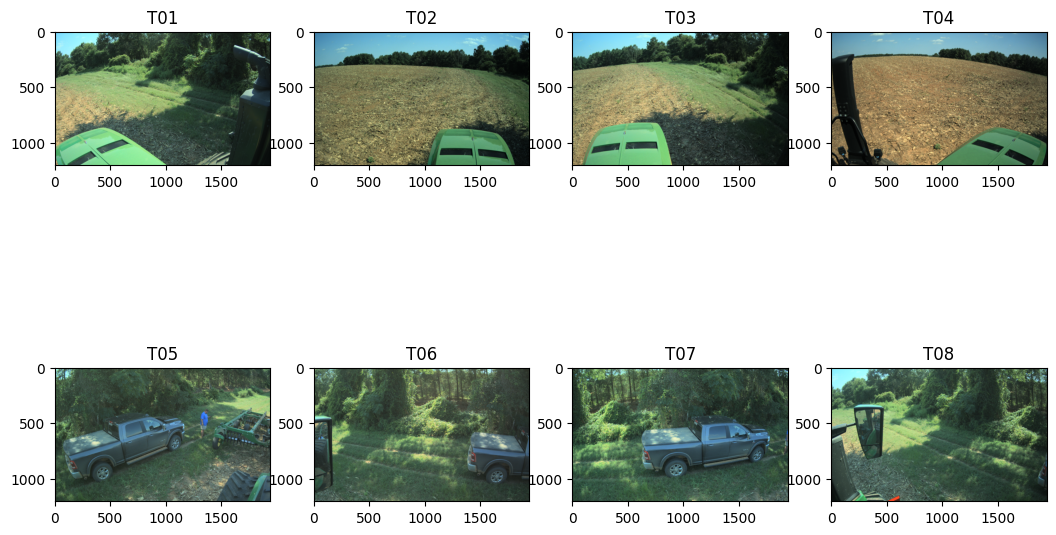

In [67]:
%matplotlib inline
show_images(stereo_df)

In [68]:
def load_intrinsic(calibration, img_shape):
    cam_intrinsics = open3d.camera.PinholeCameraIntrinsic()
    cam_intrinsics.intrinsic_matrix = np.array(calibration['intrinsics']['k']).reshape(3,3)
    cam_intrinsics.height = img_shape[0]
    cam_intrinsics.width = img_shape[1]
    return cam_intrinsics

def load_extrinsic(calibration):
    extrinsics = calibration['extrinsics']
    r = cv2.Rodrigues(np.array(extrinsics['r_rodrigues']))[0]
    t = np.array(extrinsics['t']).reshape(3,1)
    extrinsic_matrix = np.concatenate([r, t], axis=1)
    return np.concatenate([extrinsic_matrix, np.array([0,0,0,1]).reshape(1,4)], axis=0)

def load_cam_to_world(calibration):
    extrinsic_matrix = load_extrinsic(calibration)
    cam_to_world = np.linalg.inv(extrinsic_matrix)
    def convert(pointcloud):
        pointcloud_4d = np.concatenate([pointcloud, np.ones((pointcloud.shape[0], 1))], axis=1)
        pointcloud_world_coords = (cam_to_world @ pointcloud_4d.T).T
        return pointcloud_world_coords[:, :3] / pointcloud_world_coords[:, 3:]
    return convert

In [66]:
# def load_rgbd_image(obj, intensity_only=False):
#     d_np = depth_from_point_cloud(obj['point_cloud'], clip_and_normalize=False)
#     d = open3d.geometry.Image((d_np * 256).astype(np.float32))
#     rgb_np = normalize_image(obj['left'], hdr_mode=True)
#     rgb = open3d.geometry.Image(rgb_np)
#     return open3d.geometry.RGBDImage.create_from_color_and_depth(rgb, d, convert_rgb_to_intensity=intensity_only)
def load_pointcloud(row, obj):
    calibration = ast.literal_eval(row['online_calibration_results'])

    rot = obj["rectified_calibration_data"].tolist()['R1']
    rot = np.array(rot).reshape(3, 3)
    rot_inv = np.linalg.inv(rot)
    point_cloud = obj['point_cloud'].reshape(-1, 3)
    # TODO Seems wrong; Don't we need to apply distortion coefficients?
    point_cloud = (rot_inv @ point_cloud.T).T

    pts = open3d.geometry.PointCloud()
    pts.points = open3d.utility.Vector3dVector(point_cloud)
    cam_extrinsics = load_extrinsic(calibration)
    pts.transform(np.linalg.inv(cam_extrinsics))
    return pts
    # return open3d.geometry.PointCloud.create_from_rgbd_image(rgbd, cam_intrinsics, extrinsic=cam_extrinsics)

In [74]:
pcs = []
colors = []
left_images = []
for (k, row) in  stereo_df.iterrows():
    for obj, cams, label in load_object(row, get_label=True):
        pc = load_pointcloud(row, obj)
        pcs.append(pc)
        left_images.append(obj['left'].reshape(-1, 3))
left_images = np.concatenate(left_images, axis=0)
# Normalize them all together so they have the same tonemapping
left_rgb = normalize_image(left_images, hdr_mode=True)
colors.append(left_rgb.reshape(-1, 3))
# for pc in pcs:
#     pc.estimate_normals()
# pose_graph = full_registration(pcs, 0.1, max_correspondence_distance_coarse=1.0)
# for i in range(len(pcs)):
#     pcs[i].transform(pose_graph.nodes[i].pose)

full_pc = open3d.geometry.PointCloud()
for pc in pcs:
    full_pc += pc
full_pc.colors = open3d.utility.Vector3dVector(np.concatenate(colors, axis=0))    
open3d.visualization.draw_geometries([full_pc])

In [ ]:
from dl.config.label_map_helper import LabelMapHelper, LabelConversion
label_file = "/home/alexli/git/JupiterCVML/europa/base/src/europa/dl/config/label_maps/seven_class_train.csv"
merged_pointcloud = []
color_by_image = []
color_by_camera = []
color_by_label = []
color_choices_cam = get_distinct_colors(len(stereo_df))
label_map_helper = LabelMapHelper(label_file)
label_converter = LabelConversion(label_map_helper)
color_choices_label = get_distinct_colors(label_map_helper.get_num_train_classes() + 1)
for color, (_, row) in zip(color_choices_cam, stereo_df.iterrows()):
    for obj, cams, label in load_object(row, get_label=True):
        im = normalize_image(obj['left'], hdr_mode=True)[:, :, :].reshape(-1,  obj['left'].shape[2])
        label = label_converter.convert_label_for_driveable_terrain(label, json.loads(row['label_map'])).reshape(-1)
        pc = obj['point_cloud'].reshape(-1,  obj['point_cloud'].shape[2])
        calibration = ast.literal_eval(row['calibration_data'])
        cam_to_world = load_cam_to_world(calibration=calibration)
        merged_pointcloud.append(cam_to_world(pc))
        color_by_image.append(im)
        color_by_camera.append([color for _ in range(pc.shape[0])])
        color_by_label.append([color_choices_label[l + 1] if l != 255 else color_choices_label[0] for l in label])
merged_pointcloud = np.concatenate(merged_pointcloud, axis=0)
color_by_camera = np.concatenate(color_by_camera, axis=0)
color_by_image = np.concatenate(color_by_image, axis=0)
color_by_label = np.concatenate(color_by_label, axis=0)

In [ ]:
merged_pointcloud.shape

In [ ]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(merged_pointcloud)
pcd.colors = o3d.utility.Vector3dVector(color_by_label)
o3d.visualization.draw_geometries([pcd])

In [ ]:
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=0.2)
o3d.visualization.draw_geometries([voxel_grid])


In [ ]:
# import plotly.graph_objects as go
# fig = go.Figure(
#     data=[
#         go.Scatter3d(
#             x=pcs[:,0], y=pcs[:,1], z=pcs[:,2], 
#             mode='markers',
#             marker=dict(size=1, color=[list_to_plotly_color(c) for c in color_by_camera])
#         )
#     ],
#     # layout=dict(
#     #     scene=dict(
#     #         xaxis=dict(visible=False),
#     #         yaxis=dict(visible=False),
#     #         zaxis=dict(visible=False)
#     #     )
#     # )
# )
# fig.show()